In [18]:
### Packages

from dedalus import public as de
from eigentools import Eigenproblem
import h5py
import numpy as np
import matplotlib.pyplot as plt
import warnings
from IPython import display

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["New Century Schoolbook"],
    "figure.figsize": (7,4),
    "figure.constrained_layout.use": True
})

def simpleaxis(ax,xlabel,ylabel,rotation=90):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlabel(xlabel,size=18)
    ax.set_ylabel(ylabel,size=18,rotation=rotation)
    return ax

j = complex(0,1)

In [2]:
### Function for selecting eigenmodes in the dispersion relation
def getEigen(omegaT,ellT,ells,omegas,etas,modes):
    idx = ( np.abs(omegas+j*etas - omegaT) + np.abs(ells-ellT) ).argmin()
    z = omegas[idx]+j*etas[idx]
    v,w,theta,p = modes[idx]
    
    return z,ells[idx],v,w,theta,p

In [4]:
### Parameters
Nr = 64
spaceElls = np.linspace(0,40,40+1) #angular wavenumbers
driftThresh = 1e8 #tolerance for spurious modes (Eigentools parameter, inverse of eigenvalue fluctuations)
r0 = 20

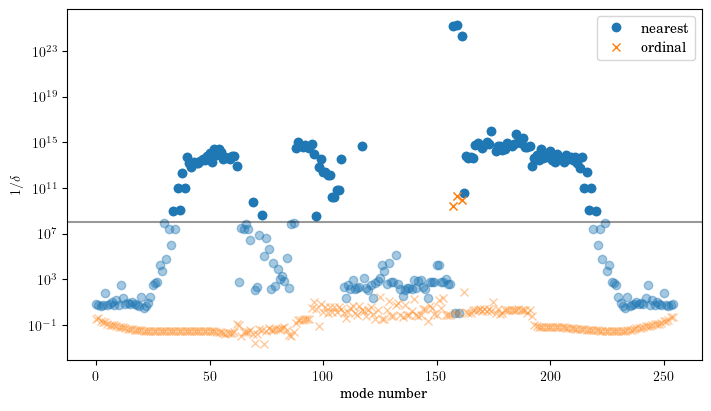

----- I find 113 modes for ℓ=40
----------------
Done!


In [17]:
### Simulation

ells, omegas, etas, modes = [],[],[],[]

rbasis = de.Chebyshev('r', Nr, interval = (-5,5))
domain = de.Domain([rbasis],  mesh=[1]) 
r = rbasis.grid(scale=1) #spatial points

#solving a problem for every value of ℓr ℓ in spaceElls:
for ℓ in spaceElls:
    #setting up EVP problem
    problem = de.EVP(domain, 
                     variables=['v','w','θ','p'], 
                     eigenvalue='σ')
    problem.meta[:]['r']['dirichlet'] = True
    
    #parameters
    csound = domain.new_field(name='cs')
    csound['g'] = 1
    bruntV = domain.new_field(name='N')
    bruntV['g'] = j
    strat = domain.new_field(name='S')
    strat['g'] = -0.1*r
    lamb = domain.new_field(name='Ll')
    lamb['g'] = csound['g'] * np.sqrt(ℓ*(ℓ+1))/(r0+r)
    
    problem.parameters['cs'] = csound
    problem.parameters['N']  = bruntV
    problem.parameters['S']  = strat
    problem.parameters['Ll']  = lamb
    problem.parameters['j']  = complex(0,1)
    
    #system of eqs
    problem.add_equation("-σ*v +  Ll*p = 0")
    problem.add_equation("-σ*w + j*N*θ -j*S*p + j*cs*dr(p) =  0")
    problem.add_equation("-σ*θ -j*N*w = 0")
    problem.add_equation("-σ*p + Ll*v +j*S*w + j*cs*dr(w) =  0")

    
    #BCs
    problem.add_bc("left(w)  =0")
    problem.add_bc("right(w) =0")
    
    #solving
    EP = Eigenproblem(problem,reject=True, drift_threshold=driftThresh, use_ordinal=False)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        EP.solve(sparse=False)
        EP.plot_drift_ratios()  #plot selection of "well-converged" modes
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.show()
    freqs = EP.evalues
    order = range(len(freqs))
    print("----- I find {} modes for ℓ={:.0f}".format(len(freqs),ℓ))

    
    #recording results
    ells     +=[ℓ                 for i in order]
    omegas   +=[np.real(freqs[i]) for i in order]
    etas     +=[np.imag(freqs[i]) for i in order]
    modes    +=[ [np.copy(EP.eigenmode(i).fields[0]['g']),np.copy(EP.eigenmode(i).fields[1]['g']),np.copy(EP.eigenmode(i).fields[2]['g']),np.copy(EP.eigenmode(i).fields[3]['g'])] for i in order]

    

omegas,etas,modes,ells = np.array(omegas),np.array(etas),np.array(modes),np.array(ells)
print("----------------")
print("Done!")

In [19]:
### Save profiles, spectrum and eigenmodes
saveFile = "data"

save_file = h5py.File('./'+saveFile+'.h5','w')
save_file['r'] = r
save_file['N'] = bruntV['g']
save_file['S'] = strat['g']
save_file['ells'] = ells
save_file['omega'] = omegas
save_file['eta'] = etas
save_file['modes'] = modes
save_file.close()

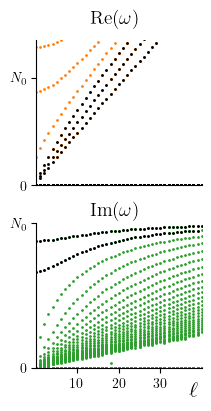

In [29]:
fig = plt.figure(figsize=(2,4))

saveFile = "data"
dat = h5py.File('./'+saveFile+'.h5','r')
ells,omegas,etas,N,S,r,modes = dat['ells'][()],dat['omega'][()],dat['eta'][()],dat['N'][()],dat['S'][()],dat['r'][()],dat['modes'][()]
dat.close()

ax = fig.add_subplot(2,1,1)
ax=simpleaxis(ax,"",r"",rotation=90)
img = ax.scatter(ells,omegas,s=1,c="tab:orange")
cond = (omegas < 0.1 + 0.064*ells)  #Select manually Exceptional modes for plotting in black
omegasPlot,etasPlot,ellsPlot = omegas[cond],etas[cond],ells[cond]
img = ax.scatter(ellsPlot,omegasPlot,s=1,c="black")
ax.text(13,1.5,r"$\mathrm{Re}(\omega)$",fontsize=14)
ax.set_yticks([-1,0,1])
ax.set_yticklabels([r"$-N_0$",r"$0$",r"$N_0$"])
ax.axis((1e-1,40,0,1.35))
ax.set_xticks(())

ax =  fig.add_subplot(2,1,2)
ax=simpleaxis(ax,r"",r"",rotation=90)
img = ax.scatter(ells,etas,s=1,c="tab:green")
cond = (etas > (0.6+ells/40*0.345)**0.9)  #Select manually Exceptional modes for plotting in black
omegasPlot,etasPlot,ellsPlot = omegas[cond],etas[cond],ells[cond]
img = ax.scatter(ellsPlot,etasPlot,s=1,c="black")
ax.text(13,1.05,r"$\mathrm{Im}(\omega)$",fontsize=14)
ax.set_yticks([-1,0,1])
ax.set_xticks([0,10,20,30])
ax.set_yticklabels([r"$-N_0$",r"$0$",r"$N_0$"])
ax.axis((1e-1,40,0,1))
ax.text(37,-0.2,r"$\ell$",fontsize=16)
plt.show()

Showing eigenmode with
ω =  0.702j , ℓ =  4.0


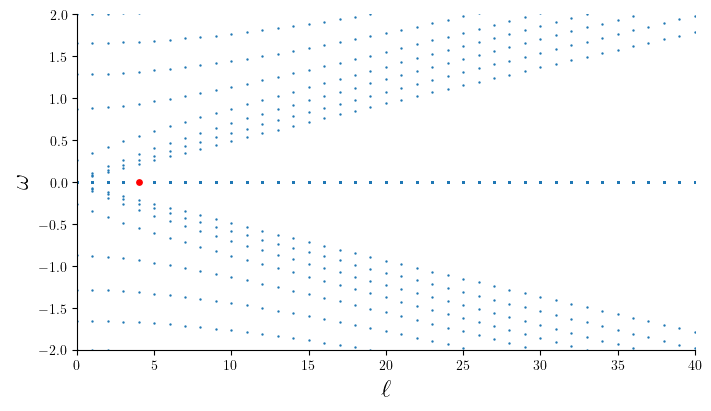

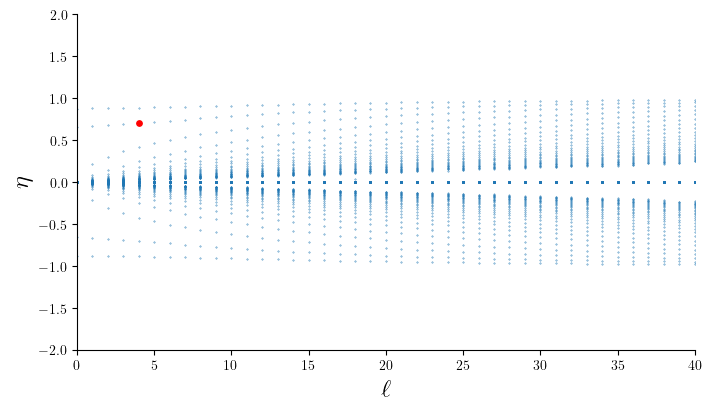

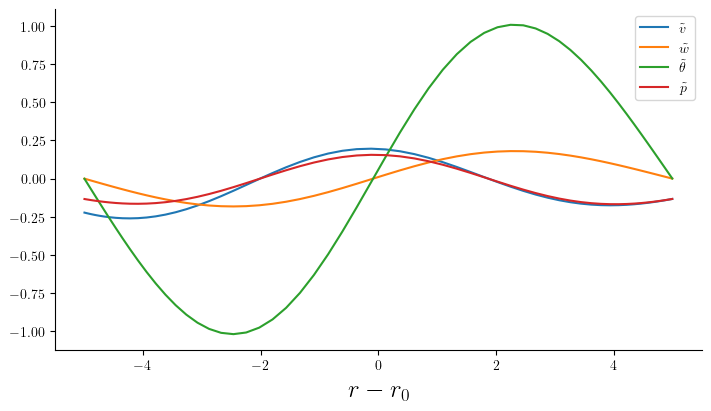

In [35]:
### Eigenmode profiles
ellT=4 #select a value of ell
omegaT= 0 + 0.7*j#select an approximate value of complex frequency
zFound,ellFound,v,w,theta,p = getEigen(omegaT,ellT,ells,omegas,etas,modes) #this returns the mode with closest eigenvalue
print("Showing eigenmode with")
print("ω = ",np.round(zFound,3),", ℓ = ",ellFound)

### Frequencies plot to eye-check which mode we found
if True:
    fig,ax = plt.subplots()
    ax=simpleaxis(ax,r"$\ell$",r"$\omega$")
    img = ax.scatter(ells,omegas,s=0.5)
    ax.scatter([ellFound],[zFound.real],s=15,c='red')
    ax.axis((spaceElls[0],spaceElls[-1],-2,2))
    plt.show()

    fig,ax = plt.subplots()
    ax=simpleaxis(ax,r"$\ell$",r"$\eta$")
    img = ax.scatter(ells,etas,s=0.1)
    ax.scatter([ellFound],[zFound.imag],s=15,c='red')
    ax.axis((spaceElls[0],spaceElls[-1],-2,2))
    plt.show()
  
fig,ax = plt.subplots()
ax=simpleaxis(ax,r"$r-r_0$","")
ax.plot(r,v.real,label=r"$\tilde{v}$")
ax.plot(r,w.real,label=r"$\tilde{w}$")
ax.plot(r,theta.real,label=r"$\tilde{\theta}$")
ax.plot(r,p.real,label=r"$\tilde{p}$")
ax.legend()
plt.show()